In [2]:
from safetensors.torch import load_file

model_ckpt = load_file("../checkpoints/svd.safetensors")

print(model_ckpt.keys())

dict_keys(['conditioner.embedders.0.open_clip.model.ln_final.bias', 'conditioner.embedders.0.open_clip.model.ln_final.weight', 'conditioner.embedders.0.open_clip.model.logit_scale', 'conditioner.embedders.0.open_clip.model.positional_embedding', 'conditioner.embedders.0.open_clip.model.text_projection', 'conditioner.embedders.0.open_clip.model.token_embedding.weight', 'conditioner.embedders.0.open_clip.model.visual.class_embedding', 'conditioner.embedders.0.open_clip.model.visual.conv1.weight', 'conditioner.embedders.0.open_clip.model.visual.ln_post.bias', 'conditioner.embedders.0.open_clip.model.visual.ln_post.weight', 'conditioner.embedders.0.open_clip.model.visual.ln_pre.bias', 'conditioner.embedders.0.open_clip.model.visual.ln_pre.weight', 'conditioner.embedders.0.open_clip.model.visual.positional_embedding', 'conditioner.embedders.0.open_clip.model.visual.proj', 'conditioner.embedders.0.open_clip.model.visual.transformer.resblocks.0.attn.in_proj_bias', 'conditioner.embedders.0.ope

In [2]:
import torch

ckpth_path = "/vol/bitbucket/abigata/checkpoints/trainstep_checkpoints/last.ckpt/checkpoint/mp_rank_00_model_states.pt"
ckpt = torch.load(ckpth_path)

print(ckpt["state_dict"].keys())

In [3]:
# create new weights for modified model
new_weights = {}
for k, v in model_ckpt.items():
    # Remove model weights
    # if k.startswith("model."):
    #     continue
    # Since embedder 1 and 2 have been removed, we need to remove the corresponding weights and change number of following embedders
    if "embedders.1" in k or "embedders.2" in k:
        print("chybrax")
        continue
    if "embedders.3" in k:
        new_weights[k.replace("embedders.3", "embedders.1")] = v
        continue
    new_weights[k] = v

In [5]:
# save new weights
from safetensors.torch import save_file

save_file(new_weights, "../checkpoints/svd_no_emb.safetensors")

In [27]:
import torch.nn.functional as F


# Function to ensure all tensors are [1, 640]
def ensure_shape(tensors, target_length=640):
    processed_tensors = []
    for tensor in tensors:
        current_length = tensor.shape[1]
        diff = current_length - target_length
        assert abs(diff) <= 5, f"Expected shape {target_length}, but got {current_length}"
        if diff < 0:
            # Calculate how much padding is needed
            padding_needed = target_length - current_length
            # Pad the tensor
            padded_tensor = F.pad(tensor, (0, padding_needed))
            processed_tensors.append(padded_tensor)
        elif diff > 0:
            # Trim the tensor
            trimmed_tensor = tensor[:, :target_length]
            processed_tensors.append(trimmed_tensor)
        else:
            # If it's already the correct size
            processed_tensors.append(tensor)
    return torch.cat(processed_tensors)

In [29]:
from decord import AVReader
from decord import cpu, gpu
import decord

decord.bridge.set_bridge("torch")

import torch

av = AVReader(
    "/vol/paramonos2/projects/antoni/code/Personal/generative-models/outputs/simple_video_sample/svd/000096_gt.mp4",
    ctx=cpu(0),
    sample_rate=16000,
)
# To access both the video frames and corresponding audio samples
audio, video = av[0:8]
# for a in audio:
#     print(a.shape)
# audio = torch.cat(audio, dim=0)
# # Each element in audio will be a batch of samples corresponding to a frame of video
# print('Frame #: ', len(audio), len(video))
# print('Shape of the audio samples of the first frame: ', audio.shape, len(audio))
# print('Shape of the first frame: ', video[0].shape)
# Similarly, to get a batch
audio2, video2 = av.get_batch(range(0, len(av)))
audio2 = ensure_shape(audio2)
print("Shape of the audio samples of the first frame: ", audio2.shape)

Shape of the audio samples of the first frame:  torch.Size([235, 640])


In [32]:
av._AVReader__video_reader

In [23]:
from einops import rearrange

raw_audio = rearrange(audio2, "t c -> (t c)")
raw_audio.shape

torch.Size([150400])

In [24]:
from scipy.io.wavfile import write

write("test.wav", 16000, raw_audio.numpy())

In [3]:
# Plot video
import moviepy.editor as mp

mp.VideoFileClip(
    "/vol/paramonos2/projects/antoni/code/Personal/generative-models/outputs/simple_video_sample/svd/000059.mp4"
).ipython_display()

Moviepy - Building video __temp__.mp4.
MoviePy - Writing audio in __temp__TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [24]:
import webdataset as wds
import glob

tar_files = glob.glob("/data/122-2/Datasets/CREMA/webdataset/train/batch_*.tar")


def preprocess_video(video):
    # Your video preprocessing code here
    return video


def preprocess_audio(audio):
    # Your audio preprocessing code here
    return audio


# Define how each type of file should be processed
def process_sample(sample):
    # Assuming the keys are 'video.mp4' and 'audio.wav' in your tar files
    video, audio = sample["mp4"], sample["wav"]

    # Apply your preprocessing functions
    processed_video = preprocess_video(video)
    processed_audio = preprocess_audio(audio)

    return processed_video, processed_audio


def custom_decoder(sample):
    # Add custom decoding or handling for specific file types
    # For example, if sample contains a '.wav' key, decode it appropriately
    print(sample.keys())
    return sample


ds = wds.WebDataset(tar_files).map(custom_decoder)
for sample in ds:
    print(sample.keys())
    break

dict_keys(['__key__', '__url__', 'mp4'])
dict_keys(['__key__', '__url__', 'mp4'])


In [87]:
import os
import ffmpeg
import tempfile


class ResolutionSubsampler:
    """
    Adjusts the resolution of the videos to the specified height and width.

    Args:
        video_size (int): Target resolution of the videos.
        resize_mode (list[str]): List of resize modes to apply. Possible options are:
            scale: scale video keeping aspect ratios (currently always picks video height)
            crop: center crop to video_size x video_size
            pad: center pad to video_size x video_size
    """

    def __init__(self, video_size, resize_mode):
        self.video_size = video_size
        self.resize_mode = resize_mode

    def __call__(self, streams):
        video_bytes = streams["video"]
        subsampled_bytes = []
        with tempfile.TemporaryDirectory() as tmpdir:
            with open(os.path.join(tmpdir, "input.mp4"), "wb") as f:
                f.write(video_bytes)
            try:
                _ = ffmpeg.input(f"{tmpdir}/input.mp4")
                if "scale" in self.resize_mode:
                    _ = _.filter("scale", -2, self.video_size)
                if "crop" in self.resize_mode:
                    _ = _.filter("crop", w=self.video_size, h=self.video_size)
                if "pad" in self.resize_mode:
                    _ = _.filter("pad", w=self.video_size, h=self.video_size)
                _ = _.output(f"{tmpdir}/output.mp4", reset_timestamps=1).run(capture_stdout=True, quiet=True)
            except Exception as err:  # pylint: disable=broad-except
                return [], None, str(err)

            with open(f"{tmpdir}/output.mp4", "rb") as f:
                subsampled_bytes = f.read()
        streams["video"] = subsampled_bytes
        return streams

In [2]:
def custom_decoder(sample):
    # Add custom decoding or handling for specific file types
    # For example, if sample contains a '.wav' key, decode it appropriately
    for key in sample.keys():
        if key.endswith("video"):
            sample[key] = wds.torch_video("mp4", sample[key])
        if key.endswith("audio"):
            sample[key] = wds.torch_audio("wav", sample[key])
        elif key.endswith("audio_emb"):
            sample[key] = wds.torch_loads(sample[key])
    return sample


import webdataset as wds

i = 0
ds = (
    wds.WebDataset("/data/122-2/Datasets/CREMA/webdataset/train/out-{000000..000006}.tar")
    .rename(video="mp4;video", audio="wav;audio", audio_emb="pt;audio_emb")
    .map(ResolutionSubsampler(256, ["scale"]))
    .map(custom_decoder)
)
for sample in ds:
    print(sample.keys())
    i += 1
    # if i > 10:
    break
print(i)

dict_keys(['__key__', '__url__', 'video', 'audio', 'audio_emb'])
1


In [13]:
import webdataset as wds

i = 0
ds = wds.WebDataset("/data/122-2/Datasets/CREMA/webdataset/train/out-{000000..000006}.tar").decode("torchl")
for sample in ds:
    print(sample.keys())
    # print(sample['mp4'][0].shape)
    print(sample["pt"].shape)
    i += 1
    # if i > 10:
    break
print(i)

dict_keys(['__key__', '__url__', 'mp4', 'pt', 'wav'])


AttributeError: 'bytes' object has no attribute 'shape'

In [23]:
with open("/data/122-2/Datasets/CREMA/s32/audio/1032_IEO_FEA_LO_emb.pt", "rb") as f:
    video = f.read()

In [4]:
import webdataset as wds

wds.autodecode.decoders
wds.autodecode.imagespecs

{'l8': ('numpy', 'uint8', 'l'),
 'rgb8': ('numpy', 'uint8', 'rgb'),
 'rgba8': ('numpy', 'uint8', 'rgba'),
 'l': ('numpy', 'float', 'l'),
 'rgb': ('numpy', 'float', 'rgb'),
 'rgba': ('numpy', 'float', 'rgba'),
 'torchl8': ('torch', 'uint8', 'l'),
 'torchrgb8': ('torch', 'uint8', 'rgb'),
 'torchrgba8': ('torch', 'uint8', 'rgba'),
 'torchl': ('torch', 'float', 'l'),
 'torchrgb': ('torch', 'float', 'rgb'),
 'torch': ('torch', 'float', 'rgb'),
 'torchrgba': ('torch', 'float', 'rgba'),
 'pill': ('pil', None, 'l'),
 'pil': ('pil', None, 'rgb'),
 'pilrgb': ('pil', None, 'rgb'),
 'pilrgba': ('pil', None, 'rgba')}

In [ ]:
from sdata import create_dataset, create_loader

from omegaconf import OmegaConf
from tqdm import tqdm

config = OmegaConf.load("/vol/paramonos2/projects/antoni/code/Personal/generative-models/notebooks/data.yaml")

# build config
datapipeline = create_dataset(**config.dataset)

i = 0
for sample in tqdm(datapipeline, desc="Loading dataset"):
    i += 1
    break

print(i)

In [10]:
datapipeline.__dict__

{'pipeline': [Dataset2SamplesConverter,
  <_map (<sdata.datapipeline.KeyPassThroughDecoder object at 0x7f1f9c6b3f40>,) {'handler': functools.partial(<function warn_and_continue at 0x7f1fd31e1480>)}>,
  <_map (<sdata.mappers.sample_mappers.SelectTuple object at 0x7f1f9c6d84c0>,) {'handler': functools.partial(<function warn_and_continue at 0x7f1fd31e1480>)}>,
  <_map (<sdata.mappers.sample_mappers.ToSVDFormat object at 0x7f1f9c6d80d0>,) {'handler': functools.partial(<function warn_and_continue at 0x7f1fd31e1480>)}>],
 'length': -1,
 'repetitions': 1,
 'nsamples': -1}

tensor([0.0316])


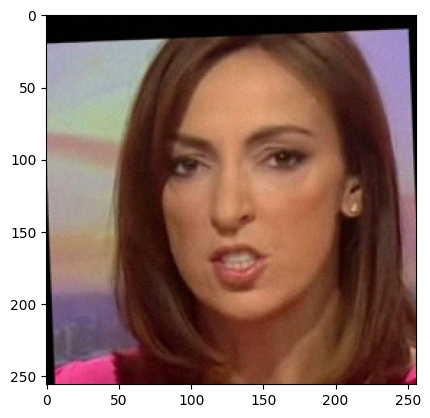

In [5]:
# Plot cond_frames
import matplotlib.pyplot as plt
import numpy as np

cond = ((sample["cond_frames"].permute(1, 2, 0).numpy() + 1) / 2).clip(0, 1) * 255
cond = cond.astype(np.uint8)
plt.imshow(cond)
print(sample["cond_aug"])